<a href="https://colab.research.google.com/github/Expert-Han/Nonlinear_Model_Predictive_Control_Python_byHan/blob/main/NMPC230225Final_Success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 17.1 MB/s eta 0:00:00


0
0.009429693222045898
1
0.008646726608276367
2
0.012624740600585938
3
0.008509159088134766
4
0.008944988250732422
5
0.009260416030883789
6
0.008977890014648438
7
0.008878469467163086
8
0.02153801918029785
9
0.009497642517089844
10
0.009227275848388672
11
0.009202003479003906
12
0.008539199829101562
13
0.00933074951171875
14
0.0092926025390625
15
0.008130073547363281
16
0.0078582763671875
17
0.008081912994384766
18
0.009354591369628906
19
0.006981372833251953
20
0.008022546768188477
21
0.009367942810058594
22
0.0077440738677978516
23
0.007754087448120117
24
0.007954120635986328
25
0.0070307254791259766
26
0.007940053939819336
27
0.0069239139556884766
28
0.008138895034790039
29
0.006954669952392578
30
0.00709843635559082
31
0.008997678756713867
32
0.01037454605102539
33
0.011855602264404297
34
0.007250547409057617
35
0.008284807205200195
36
0.00940084457397461
37
0.007174253463745117
38
0.007627725601196289
39
0.007318735122680664
40
0.007239818572998047
41
0.0070497989654541016
42
0.00

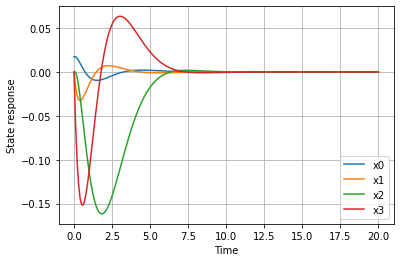

In [49]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt

# setting matrix_weights' variables
Q_x0 = 1
Q_x1 = 1
Q_x2 = 1
Q_x3 = 1
R1 = 1
M = 0.5       # mass of the cart (kg)  
m = 0.5       # mass of the pendulum bob (kg)
L = 1         # length of the pendulum rod (m)
g = 9.81      # gravity
im = 0.5      # inertia  

step_horizon = 0.1  # time between steps in seconds
N = 30              # number of look ahead steps
sim_time = 20    # simulation time

# specs
degree = 1
x0_init = degree*(np.pi)/180
x1_init = 0
x2_init = 0
x3_init = 0

x0_target = 0
x1_target = 0
x2_target = 0
x3_target = 0

v_max = 1
v_min = -1


def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())


# state symbolic variables
x0 = ca.SX.sym('x0')
x1 = ca.SX.sym('x1')
x2 = ca.SX.sym('x2')
x3 = ca.SX.sym('x3')

states = ca.vertcat(
    x0,
    x1,
    x2,
    x3
)
n_states = states.numel()

# control symbolic variables
input_u = ca.SX.sym('input_u')
controls = ca.vertcat(
    input_u)
n_controls = controls.numel()

# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)

# matrix containing all control actions over all time steps (each column is an action vector)
U = ca.SX.sym('U', n_controls, N)

# coloumn vector for storing initial state and target state
P = ca.SX.sym('P', n_states + n_states)

# state weights matrix (Q_X, Q_Y, Q_THETA)
Q = ca.diagcat(Q_x0, Q_x1, Q_x2, Q_x3)

# controls weights matrix
R = ca.diagcat(R1)


# discretization model (e.g. x2 = f(x1, v, t) = x1 + v * dt)
# rot_3d_z = ca.vertcat(
#     dx0,
#     dx1,
#     dx2,
#     dx3
# )
rot_3d_z = ca.vertcat(
    x1,
    (-m**2*(L/2)**2*sin(x0)*cos(x0)*x1**2+(M+m)*m*g*(L/2)*sin(x0)+m*(L/2)*cos(x0)*input_u)/((M+m)*(im+m*(L/2)**2)-m**2*(L/2)**2*cos(x0)**2),
    x3,
    (m**2*(L/2)**2*sin(x0)*cos(x0)*g-m*(im+m*(L/2)**2)*(L/2)*sin(x0)*x1**2+(im+m*(L/2)**2)*input_u)/((M+m)*(im+m*(L/2)**2)-m**2*(L/2)**2*cos(x0)**2))

# Mecanum wheel transfer function which can be found here: 
# https://www.researchgate.net/publication/334319114_Model_Predictive_Control_for_a_Mecanum-wheeled_robot_in_Dynamical_Environments
# RHS = states + J @ controls * step_horizon  # Euler discretization
RHS = rot_3d_z
# maps controls from [va, vb, vc, vd].T to [vx, vy, omega].T
f = ca.Function('f', [states, controls], [RHS])


cost_fn = 0  # cost function
g = X[:, 0] - P[:n_states]  # constraints in the equation


# runge kutta
for k in range(N):
    st = X[:, k]
    con = U[:, k]
    cost_fn = cost_fn \
        + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    g = ca.vertcat(g, st_next - st_next_RK4)


OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': cost_fn,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': 2000,
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -ca.inf     # X lower bound
lbx[1: n_states*(N+1): n_states] = -ca.inf     # Y lower bound
lbx[2: n_states*(N+1): n_states] = -ca.inf     # theta lower bound
lbx[3: n_states*(N+1): n_states] = -ca.inf     # theta lower bound

ubx[0: n_states*(N+1): n_states] = ca.inf      # X upper bound
ubx[1: n_states*(N+1): n_states] = ca.inf      # Y upper bound
ubx[2: n_states*(N+1): n_states] = ca.inf      # theta upper bound
ubx[3: n_states*(N+1): n_states] = ca.inf      # theta upper bound

lbx[n_states*(N+1):] = v_min                  # v lower bound for all V
ubx[n_states*(N+1):] = v_max                  # v upper bound for all V


args = {
    'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints lower bound
    'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

t0 = 0
state_init = ca.DM([x0_init, x1_init, x2_init, x3_init])        # initial state
state_target = ca.DM([x0_target, x1_target, x2_target, x3_target])  # target state

# xx = DM(state_init)
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1)         # initial state full


mpc_iter = 0
cat_states = DM2Arr(X0)
cat_controls = DM2Arr(u0[:, 0])
times = np.array([[0]])

state_temp = state_init.T
###############################################################################

if __name__ == '__main__':
    main_loop = time()  # return time in sec
    while (mpc_iter * step_horizon < sim_time):
        t1 = time()
        args['p'] = ca.vertcat(
            state_init,    # current state
            state_target   # target state
        )
        # optimization variable current state
        args['x0'] = ca.vertcat(
            ca.reshape(X0, n_states*(N+1), 1),
            ca.reshape(u0, n_controls*N, 1)
        )

        sol = solver(
            x0=args['x0'],
            lbx=args['lbx'],
            ubx=args['ubx'],
            lbg=args['lbg'],
            ubg=args['ubg'],
            p=args['p']
        )

        u = ca.reshape(sol['x'][n_states * (N + 1):], n_controls, N)
        X0 = ca.reshape(sol['x'][: n_states * (N+1)], n_states, N+1)

        cat_states = np.dstack((
            cat_states,
            DM2Arr(X0)
        ))

        cat_controls = np.vstack((
            cat_controls,
            DM2Arr(u[:, 0])
        ))
        t = np.vstack((
            t,
            t0
        ))

        t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

        # print(X0)
        X0 = ca.horzcat(
            X0[:, 1:],
            ca.reshape(X0[:, -1], -1, 1)
        )

        # xx ...
        t2 = time()
        print(mpc_iter)
        print(t2-t1)
        times = np.vstack((
            times,
            t2-t1
        ))

        mpc_iter = mpc_iter + 1
        state_temp = np.vstack([state_temp,state_init.T])


    main_loop_time = time()
    ss_error = ca.norm_2(state_init - state_target)

    # print('\n\n')
    # print('Total time: ', main_loop_time - main_loop)
    # print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
    # print('final error: ', ss_error)
tspan = np.linspace(0, 20, mpc_iter + 1)

plt.figure()
plt.plot(tspan, state_temp[:, 0], label="x0")
plt.plot(tspan, state_temp[:, 1], label="x1")
plt.plot(tspan, state_temp[:, 2], label="x2")
plt.plot(tspan, state_temp[:, 3], label="x3")
plt.grid()
plt.xlabel("Time")
plt.ylabel("State response")
plt.legend()
plt.show()

# plt.figure()
# plt.plot(tspan, u_sig[:, 0], label="u")
# plt.grid()
# plt.xlabel("Time")
# plt.ylabel("Control signal")
# plt.legend()
plt.show()
    # # simulate
    # simulate(cat_states, cat_controls, times, step_horizon, N,
    #          np.array([x_init, y_init, theta_init, x_target, y_target, theta_target]), save=False)